# Evaluating Task Performance

## Introduction

All medical images are created for a purpose, to detect, diagnose, quantify, monitor, etc. For this reason, [OIC](https://aapm.onlinelibrary.wiley.com/doi/full/10.1118/1.4881148) 

## 1. Making a Low Contrast Detectability Dataset

Using the simulation tools provided by [pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms), make a dataset of the MITA-LCD phantom (Catphan 600 CCT189 Module) at 10 dose levels with 200 repeats each using a Siemens Somatom Definition AS Scanner, this can be done with the following config file and the [`make_phantoms`](https://pediatriciqphantoms.readthedocs.io/en/latest/usage.html#command-line-interface) command line program available after [installing pediatricIQphantoms](https://github.com/DIDSR/pediatricIQphantoms?tab=readme-ov-file#start-here):

```toml
# LCD.toml

[[simulation]]

# directories
image_directory = "/gpfs_projects/brandon.nelson/RSTs/LCD-CT"
# phantoms
model = ['MITA-LCD', 'uniform'] # <-- current options include ['CTP404', 'MITA-LCD', 'UNIFORM']
diameter = [200] # <-- units in mm
reference_diameter = 200 # <-- diameter in mm of the real phantom for comparison

# acquisition
framework = "MIRT" # CT simulation framework options include ['MIRT'] <https://github.com/JeffFessler/mirt>
nsims = 200 # <-- number of simulations to perform with different noise instantiations
ndetectors = 880           # number of detector columns (set it to be large enough to cover the projected FOV to avoid truncation)
nangles = 1160 # <-- number of views in a rotation (na=1160 based on ZengEtAl2015-IEEE-NuclearScience-v62n5:"A Simple Low-Dose X-Ray CT Simulation From High-Dose Scan")
aec_on = true # (aec built in to ped xcat) <-- 'aec' = automatic exposure control, when `true`, it ensures constant noise levels for all `patient_diameters` (see `reference_dose_level` for more info)
add_noise = true # <-- if true adds Poisson noise, noise magnitude set by `reference_dose_level`, noise texture set by reconstructed field of view (currently fov = 110# patient_diameter) 
full_dose = 3e5 # <-- units of photons per pixel
dose_level = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # <-- units of photons in list

# acquisition geometry # CT geometry (the following parameter values simulate Siemens Force) 
sid = 595          #(mm) source-to-isocenter distance (value based on AAPM LDCT data dicom header)
sdd = 1085.6          # source-to-detector distance
# isocenter-to-detector distance dod = sdd - sid 
                      
detector_size = 1        # detector column size 
detector_offset = 1.25    # lateral shift of detector

# reconstruction
fov = 340  # <-- FOV in mm of adult protocol used in scanning real physical phantom for comparison
matrix_size = 512 # <-- reconstructed matrix size in pixels (square, equal on both sides)
fbp_kernel = 'hanning,2.05' # 'hanning,xxx', xxx = the cutoff frequency, see fbp2_window.m in MIRT for details.
                        #'hanning,2.05' approximate a sharp kernel D45 in Siemens Force.
                        #'hanning, 0.85' approximate a smooth kernel B30 in
                        #Siemens Force.
```

Then run the simulation using `make_phantoms`:

```bash
make_phantoms LCD.toml
```

The result as a simulated dataset of 200 repeats of the MITA-LCD phantom simulated on a Siemens Somatom Definition AS CT scanner at 10 increasing dose levels.

We can then use the Low Contrast Detectability CT Toolbox (LCD-CT) to evaluate detectability as a function of dose as demonstrated below:

(a pre-generated version is also available for download from [Zenodo](https://zenodo.org/doi/10.5281/zenodo.10064035) or use the smaller dataset)

```shell
make_phantoms LCD.toml
```

See [DIDSR/pediatricIQphantoms/running_simulations](https://pediatriciqphantoms.readthedocs.io/en/latest/notebooks/00_running_simulations.html) for more details on interactive simulations.

In [1]:
from pathlib import Path

from pediatricIQphantoms import run_batch_sim

import tomli
with open('LCD.toml', 'rb') as f:
    config_file = tomli.load(f)
config = config_file['simulation'][0]

base_dir = Path('data/small')
# base_dir = Path('data/full')

if not base_dir.exists():
    config['image_directory'] = base_dir
    config['dose_level'] = [.25, 0.5, 1]
    config['nsims'] = 5
    metadata = run_batch_sim(verbose=False, **config)
config

/home/sarah/Dev/LCD_CT/notebooks/data/small
MITA-LCD Simulation series 0/2






















uniform Simulation series 1/2


























{'image_directory': PosixPath('data/small'),
 'model': ['MITA-LCD', 'uniform'],
 'diameter': [200],
 'reference_diameter': 200,
 'framework': 'MIRT',
 'nsims': 5,
 'ndetectors': 880,
 'nangles': 1160,
 'aec_on': True,
 'add_noise': True,
 'full_dose': 3000000.0,
 'dose_level': [0.25, 0.5, 1],
 'sid': 595,
 'sdd': 1085.6,
 'detector_size': 1,
 'detector_offset': 1.25,
 'fov': 340,
 'matrix_size': 512,
 'fbp_kernel': 'hanning,2.05'}

In [2]:
!pip install matplotlib -q

In [3]:
import pandas as pd

meta = pd.read_csv(base_dir / 'metadata.csv')
meta.file = meta.file.apply(lambda o: base_dir.absolute() / o)
meta = meta[meta.phantom.isin(['MITA-LCD', 'uniform'])]
meta

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
0,20.0 cm MITA-LCD,0,750000.0 photons 20.0 cm MITA-LCD 25% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,0,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
1,20.0 cm MITA-LCD,0,750000.0 photons 20.0 cm MITA-LCD 25% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,1,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
2,20.0 cm MITA-LCD,0,750000.0 photons 20.0 cm MITA-LCD 25% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,2,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
3,20.0 cm MITA-LCD,0,750000.0 photons 20.0 cm MITA-LCD 25% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,3,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
4,20.0 cm MITA-LCD,0,750000.0 photons 20.0 cm MITA-LCD 25% dose fbp...,0,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),25.0,fbp,fbp D45,34.0,4,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
5,20.0 cm MITA-LCD,0,1500000.0 photons 20.0 cm MITA-LCD 50% dose fb...,1,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),50.0,fbp,fbp D45,34.0,0,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
6,20.0 cm MITA-LCD,0,1500000.0 photons 20.0 cm MITA-LCD 50% dose fb...,1,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),50.0,fbp,fbp D45,34.0,1,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
7,20.0 cm MITA-LCD,0,1500000.0 photons 20.0 cm MITA-LCD 50% dose fb...,1,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),50.0,fbp,fbp D45,34.0,2,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
8,20.0 cm MITA-LCD,0,1500000.0 photons 20.0 cm MITA-LCD 50% dose fb...,1,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),50.0,fbp,fbp D45,34.0,3,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
9,20.0 cm MITA-LCD,0,1500000.0 photons 20.0 cm MITA-LCD 50% dose fb...,1,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),50.0,fbp,fbp D45,34.0,4,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...


In [4]:
sorted(meta['effective diameter [cm]'].unique()), meta.series.unique()

([np.float64(20.0)],
 array(['simulation', 'noise free', 'ground truth'], dtype=object))

In [5]:
diam = 20
dose = 100
recon = 'fbp'
sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]
sample.head()

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
10,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,2,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,0,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
11,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,2,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,1,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
12,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,2,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,2,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
13,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,2,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,3,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...
14,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,2,simulation,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),100.0,fbp,fbp D45,34.0,4,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...


In [6]:
meta[(meta['effective diameter [cm]']==diam) & (meta.phantom == 'MITA-LCD') & (meta.series == 'ground truth')]

,Name,Patient ID,Study Name,Study ID,series,effective diameter [cm],age [year],pediatric subgroup,phantom,scanner,Dose [%],recon,kernel,FOV [cm],repeat,file
16,20.0 cm MITA-LCD,0,3000000.0 photons 20.0 cm MITA-LCD 100% dose f...,2,ground truth,20.0,2,infant,MITA-LCD,Siemens Definition AS+ (simulated),NaN,fbp,fbp D45,34.0,0,/home/sarah/Dev/LCD_CT/notebooks/data/small/MI...


In [7]:
meta.phantom.unique()

array(['MITA-LCD', 'uniform'], dtype=object)

In [8]:
import pydicom
import numpy as np
def load_dicom(dcm_file):
    dcm = pydicom.dcmread(dcm_file)
    return (dcm.pixel_array + int(dcm.RescaleIntercept)).astype(float)

In [9]:
diam = 20
dose = 100
recon = 'fbp'
sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]

sa_fname = sample[sample.phantom=='uniform'].file
sa_vol = np.array([load_dicom(o) for o in sa_fname])

sp_fname = sample[sample.phantom=='MITA-LCD'].file
sp_vol = np.array([load_dicom(o) for o in sp_fname])

sp_gt_vol = load_dicom(meta[(meta['effective diameter [cm]']==diam) &
                            (meta.phantom == 'MITA-LCD') &
                            (meta.series == 'ground truth')].file.item())

sp_vol.shape, sa_vol.shape, sp_gt_vol.shape

((5, 512, 512), (5, 512, 512), (512, 512))

In [10]:
# !pip install ipywidgets

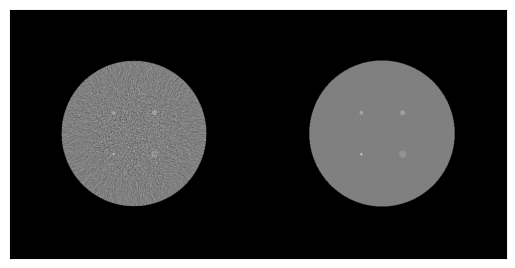

In [11]:
from utils import ctshow
ctshow(np.concatenate([sp_vol[-1], sp_gt_vol], axis=1), (40, 0))

In [12]:
!which python

/home/sarah/Dev/LCD_CT/.lcd_ct/bin/python


In [13]:
from LCD import measure_LCD

ModuleNotFoundError: No module named 'LCD'

In [ ]:
res = measure_LCD(sp_vol, sa_vol, sp_gt_vol, observers=['LG_CHO_2D', 'NPWE_2D'])
res.head()

/home/brandon.nelson/Dev/Regulatory_Science_Tools/LCD_CT/src/LCD


,observer,insert_HU,snr,auc,reader
0,Laguerre-Gauss CHO 2D,5.0,3.616415,1.0,1.0
1,Laguerre-Gauss CHO 2D,5.0,3.726306,1.0,2.0
2,Laguerre-Gauss CHO 2D,5.0,4.328612,1.0,3.0
3,Laguerre-Gauss CHO 2D,5.0,4.320447,1.0,4.0
4,Laguerre-Gauss CHO 2D,5.0,8.972216,1.0,5.0


In [ ]:
from LCD.Observers import LG_CHO, DOG_CHO, Gabor_CHO, NPWE


def get_roi_coords(center, width):
    coords = ((center[0] - width//2), (center[1] - width//2),
             (center[0] + width//2), (center[1] + width//2))
    return np.array(coords).astype(int)

def get_roi_volume(vol, coords):
    if vol.ndim == 2:
        return vol[coords[0]:coords[2], coords[1]:coords[3]]
    return vol[:, coords[0]:coords[2], coords[1]:coords[3]]

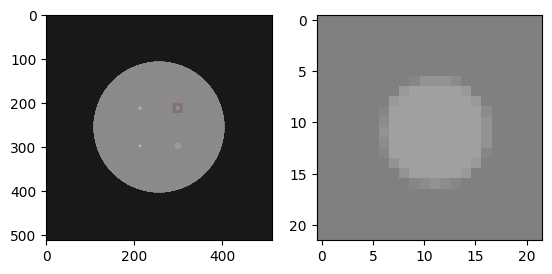

In [ ]:
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops

center = (259, 213)
width = 20

use_manual = False
if not use_manual:
    labeled_image = label(sp_gt_vol>0)
    regions = regionprops(labeled_image)
    region = regions[0]
    center = region.centroid
    width = region.axis_major_length * 2

coords = get_roi_coords(center, width)
roi = np.zeros_like(sp_gt_vol)
roi[coords[0]:coords[2], coords[1]:coords[3]] = 1000

disp = dict(cmap='gray', vmin=-20, vmax=20)
f, axs = plt.subplots(1,2)
axs[0].imshow(sp_gt_vol, **disp)
axs[0].imshow(roi, alpha=0.1, cmap='Reds')
axs[1].imshow(sp_gt_vol[coords[0]:coords[2], coords[1]:coords[3]], **disp)

In [ ]:
def get_roi_coords_from_ground_truth(ground_truth_image, thresh=0):
    labeled_image = label(ground_truth_image>thresh)
    regions = regionprops(labeled_image, intensity_image=ground_truth_image)
    coords = []
    for region in regions:
        coords.append(
            dict(center = region.centroid,
                width = region.axis_major_length * 2,
                region=region))
    return coords

In [ ]:
def measure_CCT189_detectability(sp_vol, sa_vol, sp_gt_vol, observers=['NPWE']):
    outputs = []

    rois = get_roi_coords_from_ground_truth(sp_gt_vol)
    for roi in rois:
        region = roi.pop('region')
        sp_roi = get_roi_volume(sp_vol, get_roi_coords(**roi))
        sa_roi = get_roi_volume(sa_vol, get_roi_coords(**roi))
        for observer in observers:
            radius = roi['width']
            if observer == 'LG_CHO':
                observer = eval(observer)
                observer = observer(sp_roi, sa_roi, channel_width = 2/3*radius)
            else:
                observer = eval(observer)
                observer = observer(sp_roi, sa_roi)
            out = observer.run_study()
            out['center'] = str(roi['center'])
            out['radius'] = radius
            out['insert_HU'] = region.intensity_max
            outputs.append(out)
    result = pd.concat(outputs, ignore_index=True)
    return result
    
result = measure_CCT189_detectability(sp_vol, sa_vol, sp_gt_vol, ['NPWE', 'LG_CHO'])
result








ROC CURVE DATA
--------------------------------------------------------------------------------
Cut-off point		Sensivity	Specificity
--------------------------------------------------------------------------------

ROC CURVE ANALYSIS

--------------------------------------------------------------------------------
AUC			S.E.				95% C.I.			Comment
--------------------------------------------------------------------------------
0.83333			0.21794			0.40617		1.26049			Good test
--------------------------------------------------------------------------------
Standardized AUC		1-tail p-value
1.5295				0.063076		The area is not statistically greater than 0.5







ROC CURVE DATA
--------------------------------------------------------------------------------
Cut-off point		Sensivity	Specificity
--------------------------------------------------------------------------------

ROC CURVE ANALYSIS

--------------------------------------------------------------------------------
AUC			S.E.	

,observer,auc,snr,reader,center,radius,insert_HU
0,NPWE,0.833333,1.093865,0,"(213.0, 298.0)",22.185720,5.0
1,NPWE,1.000000,1.916294,1,"(213.0, 298.0)",22.185720,5.0
2,NPWE,0.833333,0.772332,2,"(213.0, 298.0)",22.185720,5.0
3,NPWE,0.833333,1.093865,3,"(213.0, 298.0)",22.185720,5.0
4,NPWE,0.166667,-1.627616,4,"(213.0, 298.0)",22.185720,5.0
...,...,...,...,...,...,...,...
75,LG_CHO,1.000000,2.409983,5,"(298.0, 213.0)",10.179344,13.0
76,LG_CHO,0.833333,1.387913,6,"(298.0, 213.0)",10.179344,13.0
77,LG_CHO,0.833333,1.387913,7,"(298.0, 213.0)",10.179344,13.0
78,LG_CHO,1.000000,2.409983,8,"(298.0, 213.0)",10.179344,13.0


<Axes: xlabel='radius', ylabel='auc'>

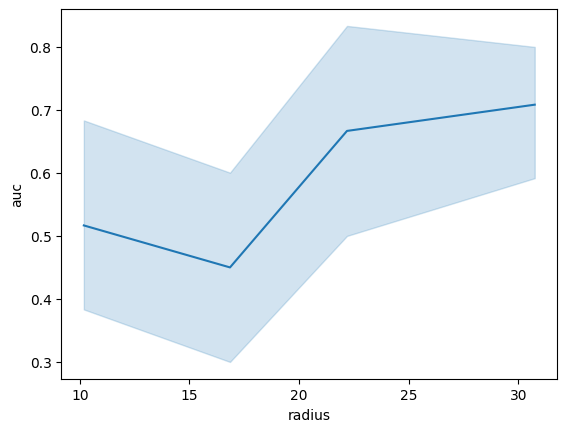

In [ ]:
import seaborn as sns
sns.lineplot(data=result, x='radius', y='auc')

In [ ]:
sp_roi = sp_vol[:, coords[0]:coords[2], coords[1]:coords[3]]
sa_roi = sa_vol[:, coords[0]:coords[2], coords[1]:coords[3]]
mo = NPWE(sp_roi, sa_roi)
mo

NPWE
signal present array shape [z, x, y]: (5, 22, 22)
signal absent array shape [z, x, y]:  (5, 22, 22)

In [ ]:
output = mo.calculate_auc(*mo.get_splits())







ROC CURVE DATA
--------------------------------------------------------------------------------
Cut-off point		Sensivity	Specificity
--------------------------------------------------------------------------------

ROC CURVE ANALYSIS

--------------------------------------------------------------------------------
AUC			S.E.				95% C.I.			Comment
--------------------------------------------------------------------------------
1.00000			0.00000			1.00000		1.00000			Perfect test
--------------------------------------------------------------------------------
Standardized AUC		1-tail p-value
Inf				0.000000		The area is statistically greater than 0.5



In [ ]:
output['auc']

1.0

In [ ]:
mo.run_study()







ROC CURVE DATA
--------------------------------------------------------------------------------
Cut-off point		Sensivity	Specificity
--------------------------------------------------------------------------------

ROC CURVE ANALYSIS

--------------------------------------------------------------------------------
AUC			S.E.				95% C.I.			Comment
--------------------------------------------------------------------------------
0.83333			0.21794			0.40617		1.26049			Good test
--------------------------------------------------------------------------------
Standardized AUC		1-tail p-value
1.5295				0.063076		The area is not statistically greater than 0.5







ROC CURVE DATA
--------------------------------------------------------------------------------
Cut-off point		Sensivity	Specificity
--------------------------------------------------------------------------------

ROC CURVE ANALYSIS

--------------------------------------------------------------------------------
AUC			S.E.	

,observer,auc,snr,reader
0,NPWE,0.833333,1.407472,0
1,NPWE,1.000000,1.916294,1
2,NPWE,0.500000,-0.410059,2
3,NPWE,0.833333,0.772332,3
4,NPWE,0.500000,0.189614,4
5,NPWE,0.833333,1.639132,5
6,NPWE,0.500000,-0.410059,6
7,NPWE,0.166667,-1.627616,7
8,NPWE,0.833333,1.093865,8
9,NPWE,0.833333,1.407472,9


If you get the error medfilt2 not found on your system, run the following:
```octave
pkg install -forge image
pkg load image
```

In [ ]:
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


<Axes: xlabel='insert_HU', ylabel='auc'>

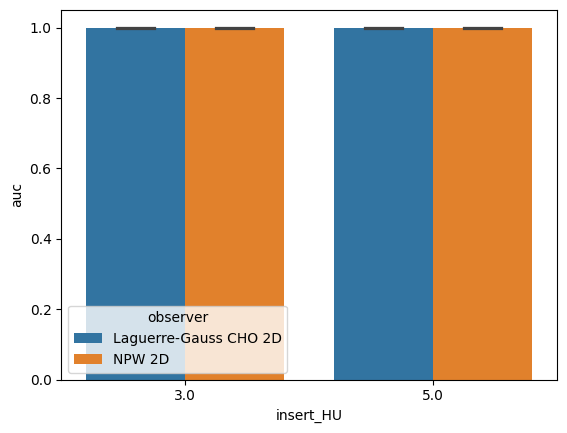

In [ ]:
import seaborn as sns
sns.barplot(data=res, x='insert_HU', y='auc', capsize=0.3, hue='observer')

In [ ]:
meta['recon'].unique()

array(['fbp'], dtype=object)

In [ ]:
df_list = []
for dose in meta['Dose [%]'].dropna().unique():
    for diam in meta['effective diameter [cm]'].unique():
        for recon in meta['recon'].unique():
            sample = meta[(meta['effective diameter [cm]'] == diam) & (meta['Dose [%]'] == dose) & (meta['recon']==recon)]

            sa_fname = sample[sample.phantom=='uniform'].file
            sa_vol = np.array([load_dicom(o) for o in sa_fname])

            sp_fname = sample[sample.phantom=='MITA-LCD'].file
            sp_vol = np.array([load_dicom(o) for o in sp_fname])

            sp_gt_vol = load_dicom(meta[(meta['effective diameter [cm]']==diam) &
                                        (meta.phantom == 'MITA-LCD') &
                                        (meta.series == 'ground truth')].file.item())

            sample_df = measure_LCD(sp_vol, sa_vol, sp_gt_vol, observers=['LG_CHO_2D', 'NPWE_2D'])
            sample_df['effective diameter [cm]'] = diam
            sample_df['Dose [%]'] = dose
            sample_df['recon'] = recon
            df_list.append(sample_df)
results = pd.concat(df_list, ignore_index=True)

/home/brandon.nelson/Dev/Regulatory_Science_Tools/LCD_CT/src/LCD














/home/brandon.nelson/Dev/Regulatory_Science_Tools/LCD_CT/src/LCD












/home/brandon.nelson/Dev/Regulatory_Science_Tools/LCD_CT/src/LCD














In [ ]:
results

,observer,insert_HU,snr,auc,reader,effective diameter [cm],Dose [%],recon
0,Laguerre-Gauss CHO 2D,5.0,2.154417,1.00,1.0,20.0,25.0,fbp
1,Laguerre-Gauss CHO 2D,5.0,1.739961,1.00,2.0,20.0,25.0,fbp
2,Laguerre-Gauss CHO 2D,5.0,2.487287,1.00,3.0,20.0,25.0,fbp
3,Laguerre-Gauss CHO 2D,5.0,2.952024,1.00,4.0,20.0,25.0,fbp
4,Laguerre-Gauss CHO 2D,5.0,0.816371,0.75,5.0,20.0,25.0,fbp
...,...,...,...,...,...,...,...,...
115,NPW 2D,3.0,3.021610,1.00,6.0,20.0,100.0,fbp
116,NPW 2D,3.0,3.465507,1.00,7.0,20.0,100.0,fbp
117,NPW 2D,3.0,7.940910,1.00,8.0,20.0,100.0,fbp
118,NPW 2D,3.0,2.767998,1.00,9.0,20.0,100.0,fbp


In [ ]:
results[results['Dose [%]'] == 60]

,observer,insert_HU,snr,auc,reader,effective diameter [cm],Dose [%],recon


In [ ]:
results['insert_HU'].unique()

array([5., 3.])

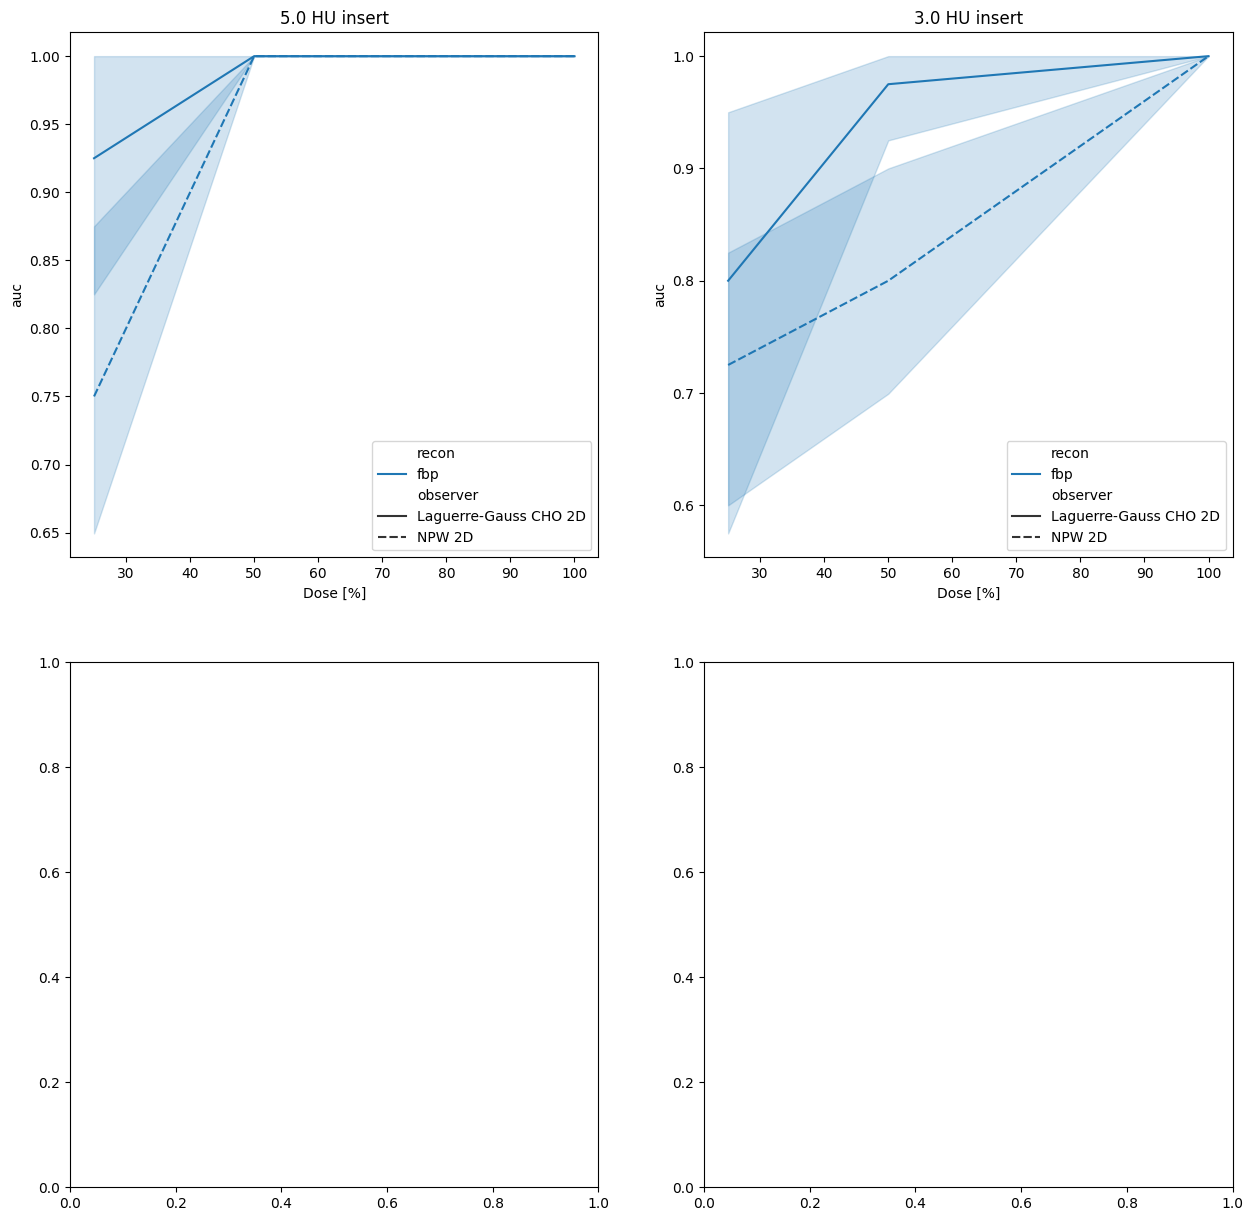

In [ ]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(2, 2, figsize=(15,15))
for ax, hu in zip(axs.flatten(), results['insert_HU'].unique()):
    sns.lineplot(data=results[results['insert_HU']==hu],
                x='Dose [%]',
                y='auc',
                hue='recon',
                style='observer', ax=ax)
    ax.set_title(f'{hu} HU insert')

Looks like denoising only helps with the really low contrast and larger lesions